In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
import pickle
import myUtils
import os
import matplotlib.pyplot as plt
from myUtils import *
from models.utils import *
from APOC import *

SEED = 84
torch.manual_seed(SEED)
warnings.simplefilter("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# can be sentiment/offensive/corona
dataset_name = 'corona'
model_type = 'gru'
model_name = 'huawei-noah/TinyBERT_General_4L_312D'
sorting = 'confidence'
delta = 0.1
folder_name = f'results/gru/{dataset_name}/{sorting}/{delta}'

In [3]:
model = torch.jit.load(f'models/{model_type}/{dataset_name}/traced.pt').to(device).eval()
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast = False)
myUtils.model = model
myUtils.tokenizer = tokenizer

In [4]:
explanations  = pickle.load(open(f"{folder_name}/exps_list.pickle", "rb" ))
anchor_examples = pickle.load(open(f"{folder_name}/anchor_examples.pickle", "rb" ))

In [5]:
print(f'anchor examples len: {len(anchor_examples)}')
print(f'explanations len: {len(explanations)}')

anchor examples len: 3744
explanations len: 72184


In [6]:
if not os.path.exists(f"{folder_name}/predictions.pickle"):
    predictions = [predict_sentences([tokenizer.tokenize(anchor_example)])[0] for anchor_example in anchor_examples]
    pickle.dump(predictions, open(f"{folder_name}/predictions.pickle", "wb" ))
    
labels = pickle.load(open(f"{folder_name}/predictions.pickle", "rb" ))

In [7]:
def get_scores_dict(top=25, trail_path = "0.1/scores.xlsx", alpha = 0.95):
    """
    returns dict of (anchor, score) pairs, and sum of the topk positive/negative
    """
    
    df = pd.read_excel(f'{folder_name}/{trail_path}').drop(0)
    
    index_prefix = f"{alpha}-" if alpha is not None else ""
    
    neg_keys = df[f'{index_prefix}negative'].dropna().tolist()
    neg_values = df.iloc[:, list(df.columns).index(f'{index_prefix}negative')+1].tolist()
    neg_scores =dict(zip(neg_keys, neg_values))    

    pos_keys = df[f'{index_prefix}positive'].dropna().tolist()
    pos_values = df.iloc[:, list(df.columns).index(f'{index_prefix}positive')+1].tolist()
    pos_scores = dict(zip(pos_keys, pos_values))
    
    return pos_scores, neg_scores

# Score calculation

In [ ]:
from functools import reduce
from collections import Counter
# get all anchor above 0.95, multiple in a sentence
def get_best(explanations):
    best_exps = dict()
    for exp in explanations:
        if exp.precision < 0.95:
            continue
        if exp.index not in best_exps.keys():
            best_exps[exp.index]=[exp]
        else:
            best_exps[exp.index].append(exp)
    print(len(best_exps))
    return reduce(lambda x,y: x+y, best_exps.values())

def get_anchor_occurences(explanations):
    c = Counter()
    for exp in explanations:
        c.update([exp.names[0]])
 
    return c

def get_normal_occurences(sentences, anchor_occurences):
    c = Counter()
    for sentence in sentences:
        c.update(tokenizer.tokenize(sentence))
   
    #removing occurences of the words as anchor
    for word in anchor_occurences.keys():
        c[word]-=anchor_occurences[word]
        
    return c

def calculate_sum(anchor_occurences, normal_occurences):
    sums = dict()
    sum_occurences = sum(anchor_occurences.values())
    for word, count in anchor_occurences.items():
        sums[word] = count/sum_occurences
    
    return sums

def calculate_avg(anchor_occurences, normal_occurences):
    avgs = dict()
    for word, count in anchor_occurences.items():
        avgs[word] = count/(anchor_occurences[word]+normal_occurences[word])
    
    return avgs

def calculate_score(score_func, agg_name):
    dfs = []
    columns = ['name', 'anchor score', 'type occurences', 'total occurences','+%', '-%', 'both', 'normal']
    
    exps = get_best(explanations)
    pos_exps = [exp for exp in exps if labels[exp.index]==0]
    neg_exps = [exp for exp in exps if labels[exp.index]==1]
    
    anchor_occurences = get_anchor_occurences(exps)
    pos_occurences = get_anchor_occurences(pos_exps)
    neg_occurences = get_anchor_occurences(neg_exps)
    
    normal_occurences = get_normal_occurences(anchor_examples, anchor_occurences)
    df_pos, df_neg = [], []
        
    teta_pos = score_func(pos_occurences, normal_occurences)
    teta_neg = score_func(neg_occurences, normal_occurences)
    
    for anchor, score in teta_pos.items():
        pos_percent = round((pos_occurences[anchor])/anchor_occurences[anchor], 2)
        neg_percent = 1-pos_percent
        both = pos_occurences[anchor]>0 and neg_occurences[anchor]>0
        df_pos.append([anchor, score , pos_occurences[anchor], anchor_occurences[anchor], pos_percent, neg_percent, both,  normal_occurences[anchor]]) 


    for anchor, score in teta_neg.items():
        pos_percent = round((pos_occurences[anchor])/anchor_occurences[anchor], 2)
        neg_percent = 1-pos_percent
        both = pos_occurences[anchor]>0 and neg_occurences[anchor]>0
        df_neg.append([anchor, score , neg_occurences[anchor], anchor_occurences[anchor], pos_percent, neg_percent, both,  normal_occurences[anchor]])
        
    df_pos.sort(key=lambda exp: -exp[1])
    df_neg.sort(key=lambda exp: -exp[1])
    df_pos = pd.DataFrame(data = df_pos, columns = columns ).set_index('name')
    df_neg = pd.DataFrame(data = df_neg, columns = columns ).set_index('name')

    dfs.extend([df_pos, df_neg])
        
    writer = pd.ExcelWriter(f'{folder_name}/{agg_name}_scores.xlsx',engine='xlsxwriter') 
    
    workbook=writer.book
    worksheet=workbook.add_worksheet('Sheet1')
    writer.sheets['Sheet1'] = worksheet
    
    cur_col = 0
    is_positive = False
    
    for df in dfs:
        cur_type = 'positive' if is_positive else 'negative'
        is_positive = not is_positive
        worksheet.write(0, cur_col, f'{cur_type}')
        df.to_excel(writer, sheet_name=f'Sheet1', startrow=1, startcol=cur_col)
        cur_col+= len(columns) + 1

    writer.save()

In [30]:
calculate_score(calculate_sum, 'sum')

871


# APOC

In [37]:
pos_scores, neg_scores = get_scores_dict(trail_path = "scores.xlsx")
pos_tokens = [k for k, v in sorted(pos_scores.items(), key=lambda item: -item[1])]
neg_tokens = [k for k, v in sorted(neg_scores.items(), key=lambda item: -item[1])]
apoc = APOCModified(model, tokenizer, anchor_examples, labels, pos_tokens, neg_tokens, f"{dataset_name} {sorting} {delta}")

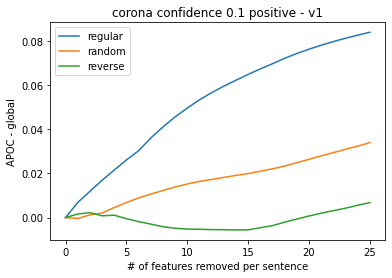

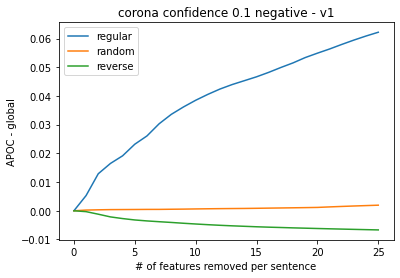

In [12]:
apoc.apoc_global('v1', 'remove')

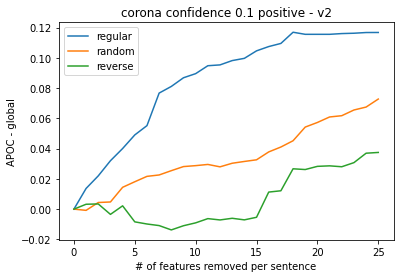

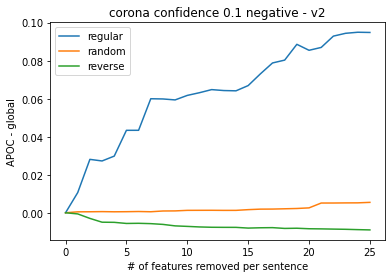

In [38]:
apoc.apoc_global('v2', 'remove')

In [ ]:
apoc.apoc_global('v1', 'replace')

In [ ]:
apoc.apoc_global('v2', 'replace')

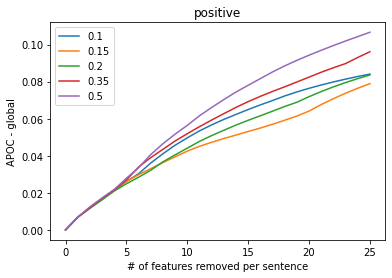

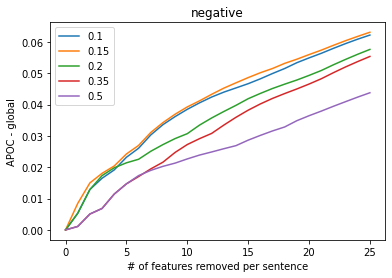

In [13]:
pos_tokens_arr = []
neg_tokens_arr = []
deltas = [0.1, 0.15, 0.2, 0.35, 0.5]
for delta in deltas:
    pos_scores, neg_scores = get_scores_dict(trail_path = f"../{delta}/scores.xlsx")
    pos_tokens, neg_tokens = list(pos_scores.keys()), list(neg_scores.keys())
    pos_tokens_arr.append(pos_tokens)
    neg_tokens_arr.append(neg_tokens)

APOCModified.compare_apocs(model, tokenizer, anchor_examples, labels, pos_tokens_arr, neg_tokens_arr, deltas)

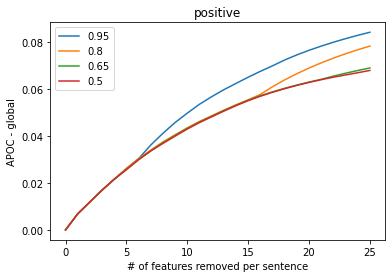

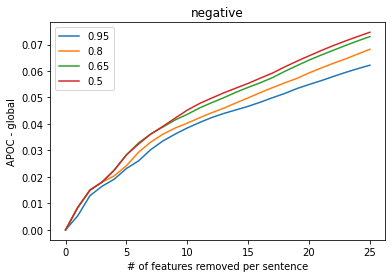

In [15]:
pos_tokens_arr = []
neg_tokens_arr = []
alphas = [0.95, 0.8, 0.65, 0.5]
for alpha in alphas:
    pos_scores, neg_scores = get_scores_dict(trail_path = "../0.1/scores.xlsx", alpha = alpha)
    pos_tokens, neg_tokens = list(pos_scores.keys()), list(neg_scores.keys())
    pos_tokens_arr.append(pos_tokens)
    neg_tokens_arr.append(neg_tokens)

APOCModified.compare_apocs(model, tokenizer, anchor_examples, labels, pos_tokens_arr, neg_tokens_arr, alphas)

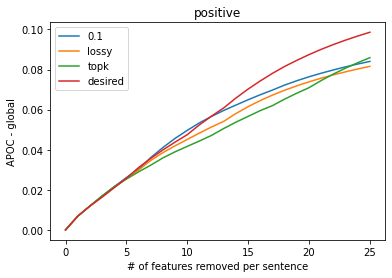

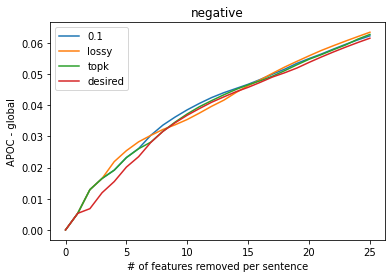

In [16]:
pos_tokens_arr = []
neg_tokens_arr = []
optimizations = [str(0.1), 'lossy', 'topk', 'desired']
for optimization in optimizations:
    pos_scores, neg_scores = get_scores_dict(trail_path = f"../{optimization}/scores.xlsx")
    pos_tokens, neg_tokens = list(pos_scores.keys()), list(neg_scores.keys())
    pos_tokens_arr.append(pos_tokens)
    neg_tokens_arr.append(neg_tokens)

APOCModified.compare_apocs(model, tokenizer, anchor_examples, labels, pos_tokens_arr, neg_tokens_arr, optimizations)

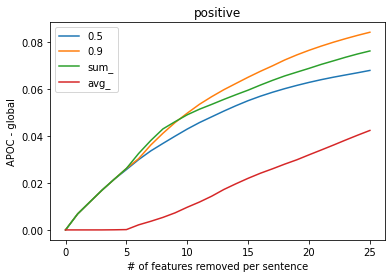

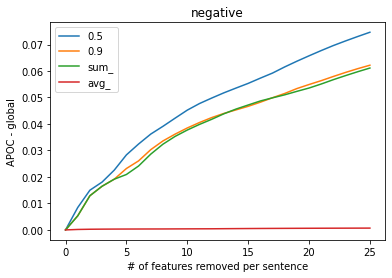

In [21]:
pos_tokens_arr = []
neg_tokens_arr = []
aggragations = ['', '', 'sum_', 'avg_']
alphas = [0.5, 0.95, None, None]
for aggragation, alpha in zip(aggragations, alphas):
    pos_scores, neg_scores = get_scores_dict(trail_path = f"../0.1/{aggragation}scores.xlsx", alpha = alpha)
    pos_tokens, neg_tokens = list(pos_scores.keys()), list(neg_scores.keys())
    pos_tokens_arr.append(pos_tokens)
    neg_tokens_arr.append(neg_tokens)
    
aggragations[0:2] = [0.5, 0.9]
APOCModified.compare_apocs(model, tokenizer, anchor_examples, labels, pos_tokens_arr, neg_tokens_arr, aggragations, num_removes = 50)

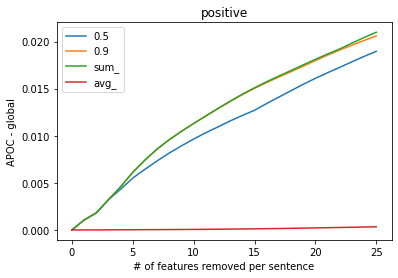

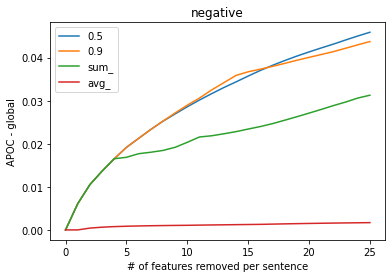

In [31]:
# sentiment
pos_tokens_arr = []
neg_tokens_arr = []
aggragations = ['', '', 'sum_', 'avg_']
alphas = [0.5, 0.95, None, None]
for aggragation, alpha in zip(aggragations, alphas):
    pos_scores, neg_scores = get_scores_dict(trail_path = f"../0.1/{aggragation}scores.xlsx", alpha = alpha)
    pos_tokens, neg_tokens = list(pos_scores.keys()), list(neg_scores.keys())
    pos_tokens_arr.append(pos_tokens)
    neg_tokens_arr.append(neg_tokens)
    
aggragations[0:2] = [0.5, 0.95]
APOCModified.compare_apocs(model, tokenizer, anchor_examples, labels, pos_tokens_arr, neg_tokens_arr, aggragations)

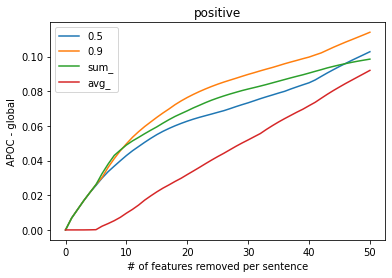

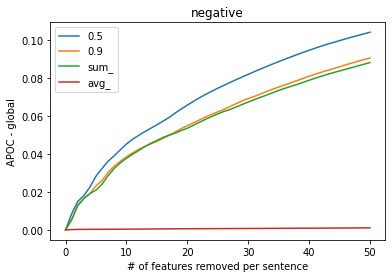

In [9]:
pos_tokens_arr = []
neg_tokens_arr = []
aggragations = ['', '', 'sum_', 'avg_']
alphas = [0.5, 0.95, None, None]
for aggragation, alpha in zip(aggragations, alphas):
    pos_scores, neg_scores = get_scores_dict(trail_path = f"../0.1/{aggragation}scores.xlsx", alpha = alpha)
    pos_tokens, neg_tokens = list(pos_scores.keys()), list(neg_scores.keys())
    pos_tokens_arr.append(pos_tokens)
    neg_tokens_arr.append(neg_tokens)
    
aggragations[0:2] = [0.5, 0.9]
APOCModified.compare_apocs(model, tokenizer, anchor_examples, labels, pos_tokens_arr, neg_tokens_arr, aggragations)